In [6]:
import findspark
findspark.init()


In [7]:
from pyspark.sql import SparkSession
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType



In [61]:
spark = SparkSession.builder.appName("nyc-job").getOrCreate()

26/02/19 17:31:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Load the dataset

In [62]:
df = spark.read.csv("nyc-jobs.csv", header=True)
df.printSchema()

root
 |-- Job ID: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: string (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: string (nullable = true)
 |-- Salary Range To: string (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locatio

### Missing Value Profile

In [11]:
#-- count the null in each column
df.select([count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns]).show(vertical=True, truncate=False)

26/02/19 17:12:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0-----------------------------
 Job ID                        | 0    
 Agency                        | 0    
 Posting Type                  | 0    
 # Of Positions                | 0    
 Business Title                | 0    
 Civil Service Title           | 0    
 Title Code No                 | 0    
 Level                         | 0    
 Job Category                  | 2    
 Full-Time/Part-Time indicator | 195  
 Salary Range From             | 0    
 Salary Range To               | 0    
 Salary Frequency              | 0    
 Work Location                 | 0    
 Division/Work Unit            | 0    
 Job Description               | 0    
 Minimum Qual Requirements     | 18   
 Preferred Skills              | 259  
 Additional Information        | 563  
 To Apply                      | 180  
 Hours/Shift                   | 1062 
 Work Location 1               | 1138 
 Recruitment Contact           | 1763 
 Residency Requirement         | 678  
 Posting Date            

In [15]:
def clean_column_names(df):
    for c in df.columns:
        new_c = (
            c.strip()
             .lower()
             .replace(" ", "_")
             .replace("-", "_")
             .replace("/", "_")
             .replace("(", "")
             .replace(")", "")
        )
        df = df.withColumnRenamed(c, new_c)
    return df
df=clean_column_names(df)

In [24]:
def prepare_df(df):

    df = clean_column_names(df)
    # casting 
    df = (
        df
        .withColumn("salary_range_from", col("salary_range_from").cast(DoubleType()))
        .withColumn("salary_range_to", col("salary_range_to").cast(DoubleType()))
        .withColumn("posting_date", to_date(col("posting_date")))
    )

    # average salary 
    df = df.withColumn(
        "avg_salary",
        (col("salary_range_from") + col("salary_range_to")) / 2
    )
    # annual salary 
    df = df.withColumn(
        "annual_salary",
        when(col("salary_frequency") == "Hourly", col("avg_salary") * 2080)
        .when(col("salary_frequency") == "Daily", col("avg_salary") * 260)
        .when(col("salary_frequency") == "Weekly", col("avg_salary") * 52)
        .otherwise(col("avg_salary"))
    )

    #degree flag
    df = df.withColumn(
        "requires_degree",
        when(
            lower(col("minimum_qual_requirements"))
            .rlike("bachelor|master|phd|degree"),
            1
        ).otherwise(0)
    )

    #posting year 
    df = df.withColumn("posting_year", F.year("posting_date"))

    #salary bucket
    df = df.withColumn(
        "salary_bucket",
        when(col("annual_salary") < 60000, "low")
        .when(col("annual_salary") < 100000, "mid")
        .otherwise("high")
    )

    # Feature removal
    df = df.drop(
        "to_apply",
        "additional_information",
        "recruitment_contact"
    )

    return df
df=prepare_df(df)

# Whats the number of jobs posting per category (Top 10)?

In [47]:
import pyspark.sql.functions as F
def top10_job_categories(df,top_n = 10):
    return (
        df.groupBy("job_category")
          .count()
          .orderBy(F.desc("count"))
          .limit(top_n)
    )

top10_job_categories(df).show()

+--------------------+-----+
|        job_category|count|
+--------------------+-----+
|Engineering, Arch...|  504|
|Technology, Data ...|  313|
|       Legal Affairs|  226|
|Public Safety, In...|  182|
|Building Operatio...|  181|
|Finance, Accounti...|  169|
|Administration & ...|  134|
|Constituent Servi...|  129|
|              Health|  125|
|Policy, Research ...|  124|
+--------------------+-----+



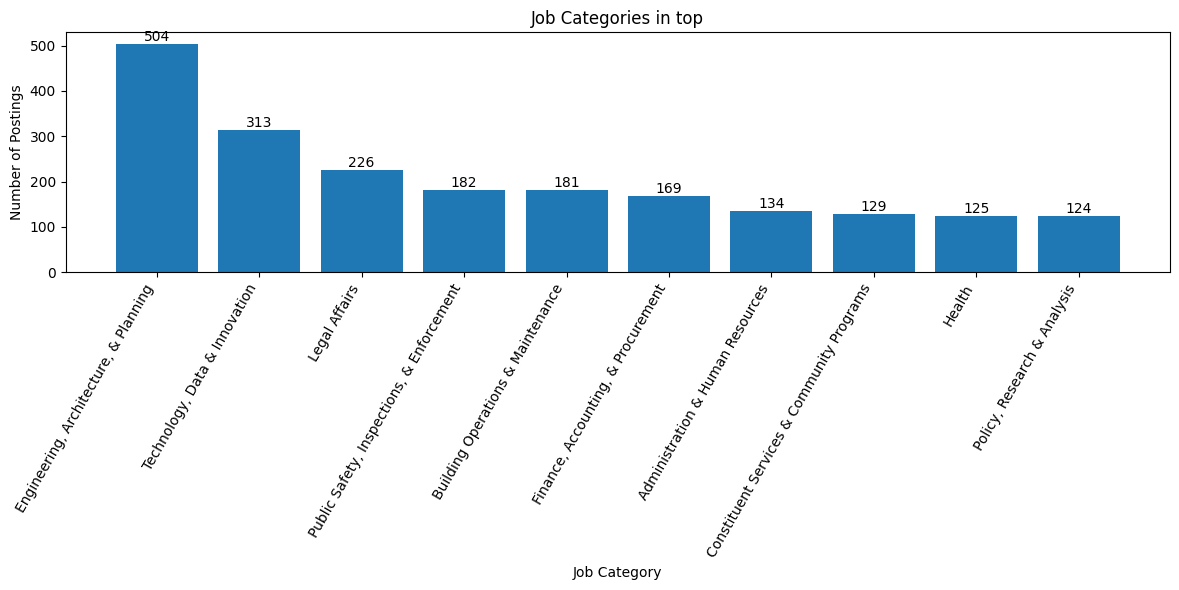

In [26]:
pdf = top10_job_categories(df).toPandas()

plt.figure(figsize=(12,6))

bars = plt.bar(pdf["job_category"], pdf["count"])

# rotate + right-align labels so they don’t overlap
plt.xticks(rotation=60, ha="right")

plt.title("Job Categories in top")
plt.xlabel("Job Category")
plt.ylabel("Number of Postings")

#add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        int(height),
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

# Whats the salary distribution per job category?

In [27]:
## Salary distribution per job category


def kpi_salary_distribution_per_category(df):


    return (
        df
        .filter(F.col("annual_salary").isNotNull())
        .groupBy("job_category")
        .agg(
            F.count("*").alias("job_count"),
            F.min("annual_salary").alias("min_salary"),
            F.expr("percentile(annual_salary, 0.25)").alias("p25"),
            F.expr("percentile(annual_salary, 0.50)").alias("median_salary"),
            F.expr("percentile(annual_salary, 0.75)").alias("p75"),
            F.max("annual_salary").alias("max_salary"),
            F.avg("annual_salary").alias("avg_salary")
        )
        .orderBy(F.col("avg_salary").desc())
    )
dist_df = kpi_salary_distribution_per_category(df)
final_dist_df = dist_df.filter(F.col("job_count") > 10).orderBy(F.col("job_count").desc())
final_dist_df.show()

+--------------------+---------+----------+---------+-------------+----------+----------+-----------------+
|        job_category|job_count|min_salary|      p25|median_salary|       p75|max_salary|       avg_salary|
+--------------------+---------+----------+---------+-------------+----------+----------+-----------------+
|Engineering, Arch...|      504|   43415.5|  69283.5|      81478.0|  97693.75|  151795.0|85503.04563492064|
|Technology, Data ...|      313|   32957.6|  77085.0|      93825.5|  105000.0|  169011.0|90939.57863258784|
|       Legal Affairs|      226|   37398.0|  67970.0|      82381.5|   98580.5|  191913.0| 84739.9537876106|
|Public Safety, In...|      182|   29561.0|  47033.5|      56192.0|   76234.0|  140659.0|63608.94556043956|
|Building Operatio...|      181|   36267.5|  49053.5|      73195.2|   93225.6|  169011.0|73831.78972375693|
|Finance, Accounti...|      169|   21539.5|  57500.0|      70000.0|   84267.5|  167500.0|74945.58118343195|
|Administration & ...|      

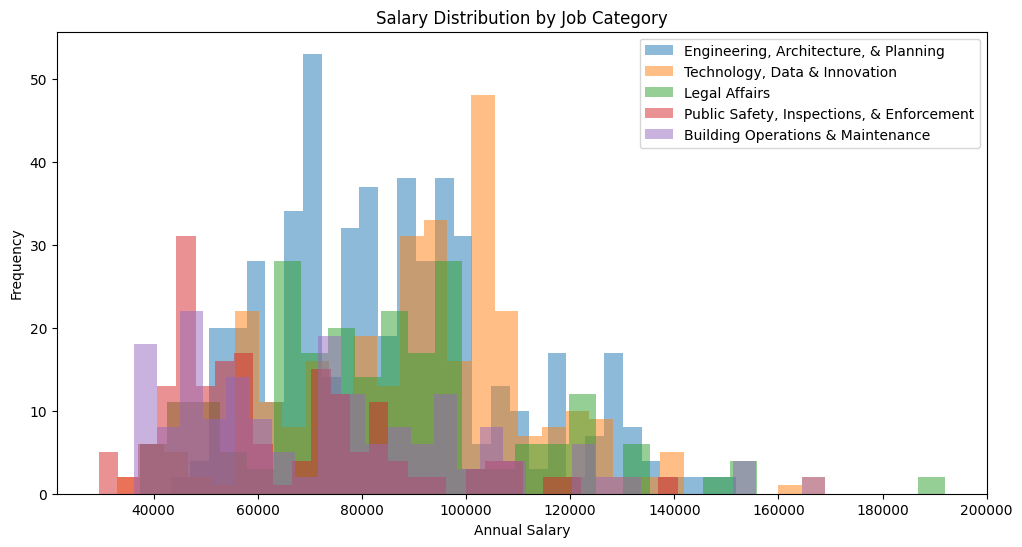

In [30]:
#Top 5 categories
#normalized salary to annual values, grouped by job category, and computed distribution metrics including quartiles 
#and median using Spark percentile functions. 

top_cats = (
    df.groupBy("job_category")
       .count()
       .orderBy(F.desc("count"))
       .limit(5)
       .select("job_category")
       .toPandas()["job_category"]
       .tolist()
)

pdf = (
    df.filter(F.col("job_category").isin(top_cats))
        .select("job_category", "annual_salary")
        .dropna()
        .toPandas()
)

plt.figure(figsize=(12,6))

for cat in top_cats:
    subset = pdf[pdf["job_category"] == cat]
    plt.hist(subset["annual_salary"], bins=30, alpha=0.5, label=cat)

plt.legend()
plt.title("Salary Distribution by Job Category")
plt.xlabel("Annual Salary")
plt.ylabel("Frequency")
plt.show()

# Is there any correlation between the higher degree and the salary?

In [32]:
# Correlation Analysis (Pearson correlation)
def degree_salary_correlation(df):


    df_corr = (
        df
        .select("requires_degree", "annual_salary")
        .dropna()
    )

    return df_corr.stat.corr("requires_degree", "annual_salary")

corr_value = degree_salary_correlation(df)
print("Correlation:", corr_value)






Correlation: 0.13691117605255004


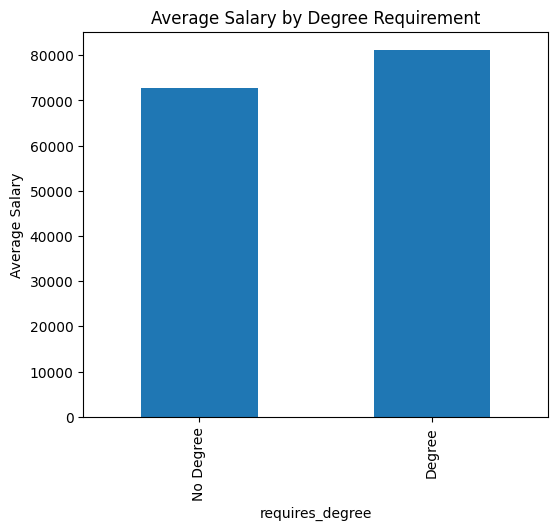

In [34]:
df_plot = (
    df
    .select("requires_degree", "annual_salary")
    .dropna()
    .sample(fraction=0.3, seed=42)   # sample for faster plotting
    .toPandas()
)

means = df_plot.groupby("requires_degree")["annual_salary"].mean()

plt.figure(figsize=(6,5))
means.plot(kind="bar")

plt.xticks([0,1], ["No Degree", "Degree"])
plt.ylabel("Average Salary")
plt.title("Average Salary by Degree Requirement")

plt.show()

# Whats the job posting having the highest salary per agency?

In [36]:
def highest_salary_job_per_agency(df_prepared):

    #Rank Jobs by Salary Within Each Agency
    w = Window.partitionBy("Agency").orderBy(F.col("annual_salary").desc())

    result = (
        df_prepared
        .filter(F.col("annual_salary").isNotNull())
        .withColumn("rank", F.row_number().over(w))
        .filter(F.col("rank") == 1)
        .select(
            "agency",
            #"Job ID",
            "business_title",
            #"job_category",
            "annual_salary"
        )
        .orderBy(F.col("annual_salary").desc())
    )

    return result

top_jobs = highest_salary_job_per_agency(df)
top_jobs.show(truncate=False)


+------------------------------+------------------------------------------------------------+------------------+
|agency                        |business_title                                              |annual_salary     |
+------------------------------+------------------------------------------------------------+------------------+
|DEPT OF ENVIRONMENT PROTECTION|Deputy Commissioner, Bureau of Customer Services            |218587.0          |
|POLICE DEPARTMENT             |Deputy Commissioner, Public Information, M-VII              |217201.0          |
|DISTRICT ATTORNEY KINGS COUNTY|Co-Chief Information Officer                                |191913.0          |
|NYC HOUSING AUTHORITY         |Vice-President for Support Services                         |180000.0          |
|NYC EMPLOYEES RETIREMENT SYS  |ADMINISTRATIVE MANAGEMENT AUDITOR                           |177374.5          |
|DEPT OF HEALTH/MENTAL HYGIENE |Physician, Bureau of Sexually Transmitted Infections        |170

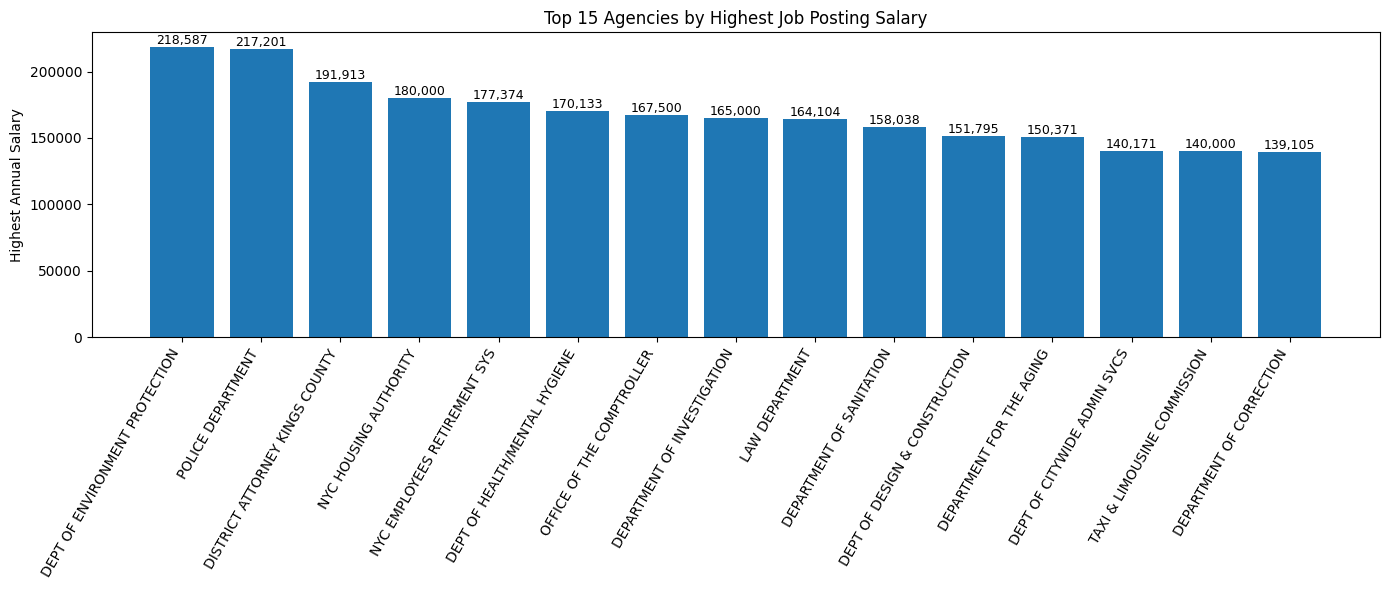

In [37]:
plot_pdf = top_jobs.limit(15).toPandas()

plt.figure(figsize=(14,6))

bars = plt.bar(plot_pdf["agency"], plot_pdf["annual_salary"])

plt.xticks(rotation=60, ha="right")
plt.ylabel("Highest Annual Salary")
plt.title("Top 15 Agencies by Highest Job Posting Salary")

# show values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height):,}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

# Whats the job positings average salary per agency for the last 2 years?

In [ ]:
def avg_salary_per_agency_last_2_years(df):

    max_year = df.select(F.max("posting_year")).first()[0]

    result = (
        df
        .filter(
            (F.col("posting_year") >= max_year - 1) & F.col("annual_salary").isNotNull()
        ).groupBy("agency").agg(F.avg("annual_salary").alias("avg_salary"),F.count("*").alias("job_count"))
        .orderBy(F.col("avg_salary").desc())
    )

    return result

avg_salary_2yr = avg_salary_per_agency_last_2_years(df)
avg_salary_2yr.show(20, truncate=False)

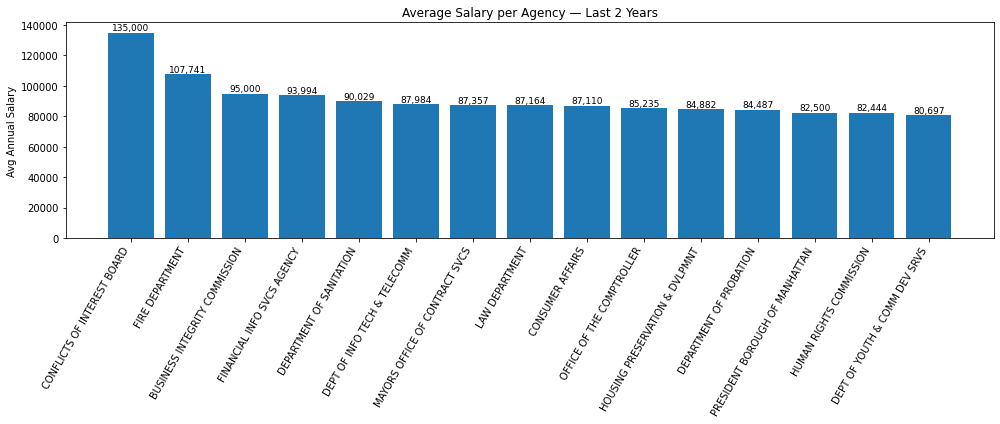

In [607]:
pdf = avg_salary_2yr.limit(15).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
bars = plt.bar(pdf["agency"], pdf["avg_salary"])

plt.xticks(rotation=60, ha="right")
plt.ylabel("Avg Annual Salary")
plt.title("Average Salary per Agency — Last 2 Years")

for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, f"{int(h):,}",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# What are the highest paid skills in the US market?

In [41]:

def highest_paid_skills(df, min_count=10):

    skills_df = (
        df
        .withColumn("skill", F.explode(F.split(F.col("preferred_skills"), ",")))
        .withColumn("skill", F.trim(F.lower(F.col("skill"))))
        .filter(F.col("skill") != "")
    )
    result = (
        skills_df
        .groupBy("skill")
        .agg(
            F.count("*").alias("jobs"),
            F.avg("annual_salary").alias("avg_salary")
        )
        .filter(F.col("jobs") >= min_count)
        .orderBy(F.col("avg_salary").desc())
    )

    return result
top_skills = highest_paid_skills(df)
top_skills.show(20)

+--------------------+----+------------------+
|               skill|jobs|        avg_salary|
+--------------------+----+------------------+
|        presentation|  10|         120875.55|
|""b"" and ""c"" a...|  46|109698.89130434782|
|""2"" or ""3"" ab...|  54|109464.47577777777|
|               state|  12|          108643.0|
|          managerial|  58|104545.12068965517|
|all candidates mu...|  24|103625.47916666667|
|all candidates mu...|  10|          103494.9|
|                  c#|  10|          102009.5|
|         engineering|  10|          96401.55|
|including one yea...|  39| 94998.83333333333|
|                 css|  12| 94470.91666666667|
|including the 18 ...|  56| 94241.09821428571|
|all candidates mu...|  28| 94221.82142857143|
|          javascript|  18|           93483.5|
|       error: #name?|  22| 93161.73545454546|
|      employment law|  10|           91544.4|
|accredited by reg...|  23| 91445.93652173913|
|in addition to me...|  44| 90968.77272727272|
|       inter

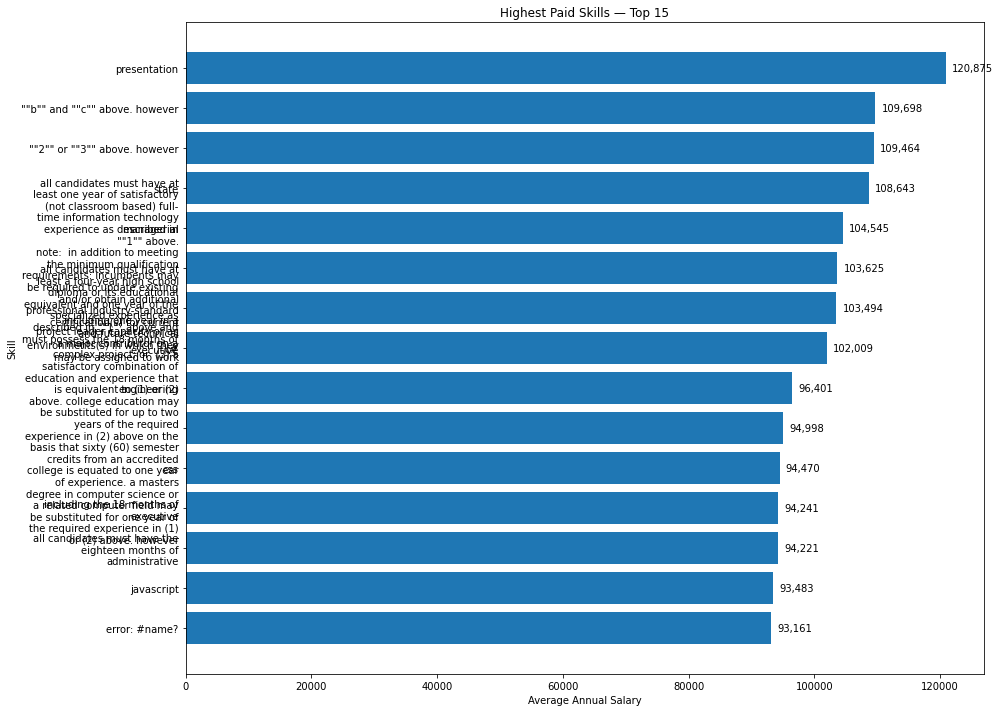

In [609]:
pdf = top_skills.limit(15).toPandas()
pdf["skill"] = pdf["skill"].apply(lambda x: "\n".join(textwrap.wrap(x, 30)))


plt.figure(figsize=(14, 10))

bars = plt.barh(pdf["skill"], pdf["avg_salary"])

plt.title("Highest Paid Skills — Top 15")
plt.xlabel("Average Annual Salary")
plt.ylabel("Skill")

# invert so highest is on top
plt.gca().invert_yaxis()

# Add salary labels on bars
for i, v in enumerate(pdf["avg_salary"]):
    plt.text(v + 1000, i, f"{int(v):,}", va='center')

plt.tight_layout()
plt.show()

# Test Cases

In [42]:
def test_processed_df_quality(df):

    assert "annual_salary" in df.columns
    assert "requires_degree" in df.columns

    null_rate = df.filter(col("annual_salary").isNull()).count() / df.count()
    assert null_rate < 0.3

    print("Data quality tests passed")

In [48]:
def top_categories_test(df):

    out = top10_job_categories(df)

    assert out.count() <= 10
    assert "job_category" in out.columns
    assert "count" in out.columns
    assert out.filter(col("count") <= 0).count() == 0

    print("Top categories KPI test has been passed")

top_categories_test(df)    

Top categories KPI test has been passed


In [49]:
def salary_distribution_test(df):

    out = salary_distribution_per_category(df)

    required_cols = [
        "job_category",
        "job_count",
        "min_salary",
        "max_salary",
        "avg_salary"
    ]

    for c in required_cols:
        assert c in out.columns

    assert out.filter(col("avg_salary") <= 0).count() == 0

    print("salary distribution KPI test has been passed")


In [50]:
def test_degree_correlation(df):

    corr = degree_salary_correlation(df)

    assert corr is not None
    assert -1 <= corr <= 1

    print("KPI correlation test has been passed:", corr)

In [51]:
def test_highest_salary_per_agency(df):

    out = highest_salary_job_per_agency(df)

    assert "agency" in out.columns
    assert "annual_salary" in out.columns

    # each agency should appear once
    assert out.count() == out.select("agency").distinct().count()

    print("highest salary KPI per agency test has been passed")

In [52]:
def test_avg_salary_last2yrs(df):

    out = avg_salary_per_agency_last_2_years(df)

    assert "agency" in out.columns
    assert "avg_salary" in out.columns

    assert out.filter(col("avg_salary") <= 0).count() == 0

    print("avg salary KPI last 2 yrs test has been passed")

In [53]:
def test_highest_paid_skills(df):
    

    out = highest_paid_skills(df)

    assert "skill" in out.columns
    assert "avg_salary" in out.columns

    assert out.count() > 0
    assert out.filter(col("avg_salary") <= 0).count() == 0

    print("highest paid KPI skills test has been passed")

In [58]:
def run_all_kpi_tests(df):

    top_categories_test(df)
    #salary_distribution_test(df)
    test_degree_correlation(df)
    test_highest_salary_per_agency(df)
    test_avg_salary_last2yrs(df)
    test_highest_paid_skills(df)

    print("ALL KPI TESTS PASSED")

# Run All Tests

In [ ]:
test_processed_df_quality(df)
run_all_kpi_tests(df)

### Example helper function

In [619]:
def get_salary_frequency(df) -> list:
    row_list = df.select('Salary Frequency').distinct().collect()
    return [row['Salary Frequency'] for row in row_list]

### Illustration of test method

In [620]:
mock_data = [('A', 'Annual'), ('B', 'Daily')]
expected_result = ['Annual', 'Daily']

In [621]:
def test_get_salary_frequency(mock_data: list, 
                              expected_result: list,
                              schema: list = ['id', 'Salary Frequency']):  
    mock_df = spark.createDataFrame(data = mock_data, schema = schema)
    assert get_salary_frequency(mock_df) == expected_result